# Data Exploration for Product Category Mismatch

## Problem Description
One major source of income for our company is the selling of items on Amazon. One of the factors that we must estimate decide which products to buy is the product's sales per month, or SPM. We currently estimate this using the sales rank average and product category given to us by the Keepa API.
However, we notice that for many products, this estimate is off by orders of magnitude. This is particularly bad if that estimate is very high and causes us to purchase a product in a large quantity that actually will not sell.

## Objective
I want to experiment with and analyze other ways of calculating a product's SPM in hopes of improving our current estimate.

## Our Data
Unfortunately, I find that Amazon does not reveal any sales data for their products, so we are unable to rely on any form of machine learning models to quickly solve this problem. This makes the problem much more difficult since we have no true objective measure of how much products would sell, so we are tasked with deriving measures of product sales that are convincing enough to be accepted.

The data I will be using comes from the Keepa API, which collects and maintains data on almost all of Amazon's products. That data includes the history of a product's sales rank, which would be the field I will focus on. Every product is ranked within its main category against all other products in that same category. That ranking is based on the amount the given product sells in relation with the other products in its category, so that more popular items will have a lower ranking and less popular items will have a higher ranking.

An example of a product's sales rank history is shown below.

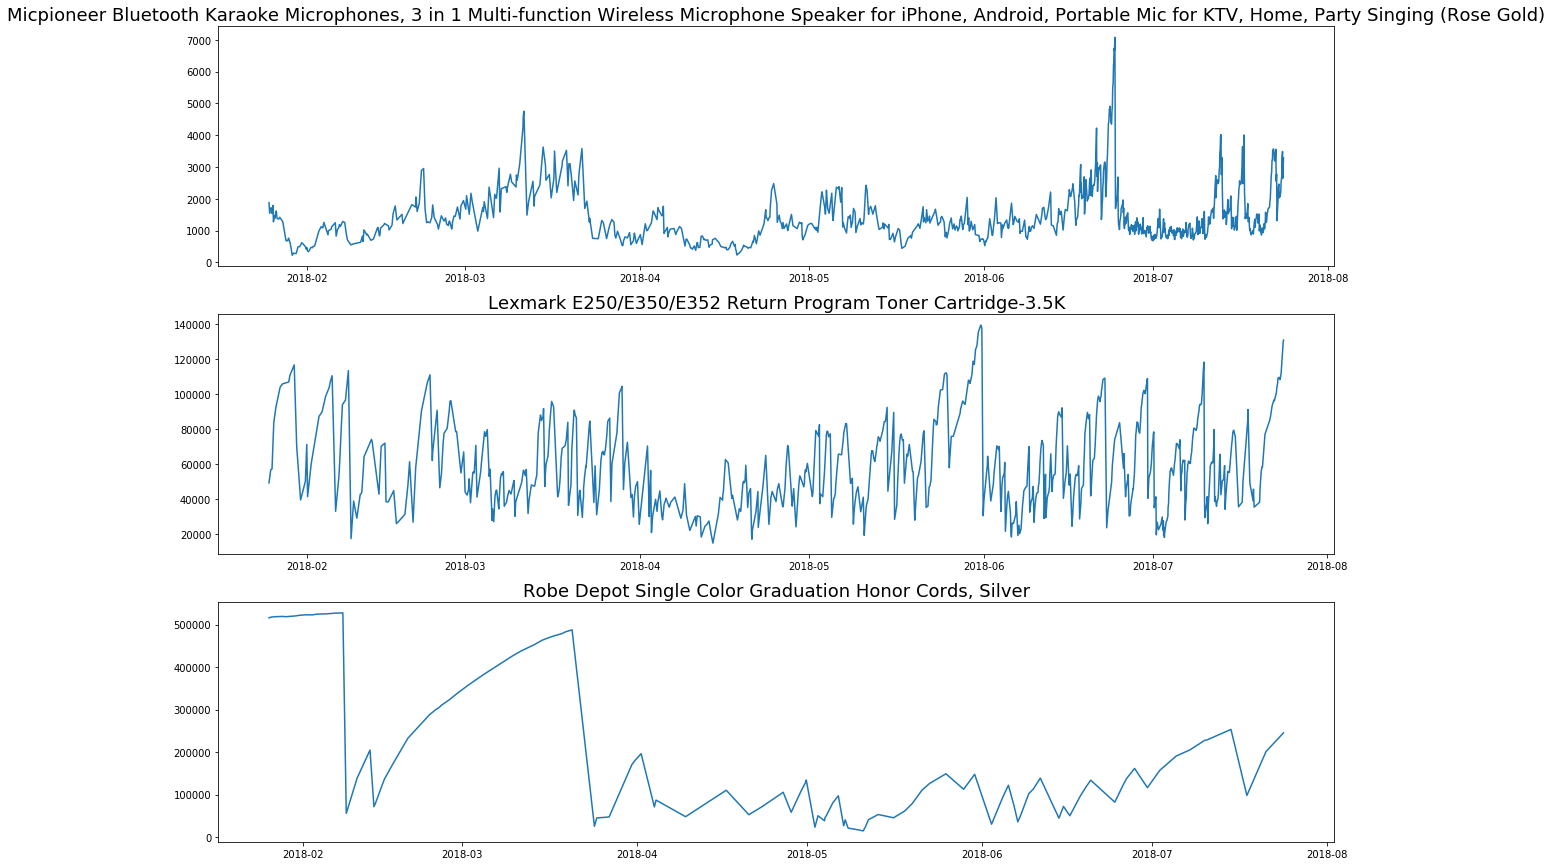

In [4]:
import os
import time
import gzip
import math
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
import logging
import scipy
import json
from tqdm import tnrange, tqdm_notebook, tqdm
from scipy import stats
import matplotlib.pyplot as plt

def category_id_change( keepa_data , id_convert_table ):

    """Converts the root_category id to a string that can be looked up in the interpolation table.
        
    Arguments:
       keepa_data (dict): The keepa blob
       id_convert_table (DataFrame): A conversion table for different categories (found in the working directory)
    
    Returns: 
       A string that corresponds to the root_category_id for the interpolation lookup table.
    """

    root_category = keepa_data['rootCategory']

    if root_category in id_convert_table.index:

        category_string = id_convert_table.loc[ root_category, 'spm_tool_name' ]
        return category_string

    else:
        return None

def extract_sales_data(keepa_data):   
    """Processes a single raw Keepa data entry and returns it as a dict.
    
    Arguments:
        keepa_data (dict): The raw Keepa data entry.
        
    Returns:
        product_data (dict): A dictionary in the form of {'asin' : asin, 'SALES':[(timestamp,sales rank),...]},
        sorted chronologically by timestamp.
    """
    csv=keepa_data['csv']
    index = [ 3, 'SALES']
    product_data = {}
    ind = index[0]
    if csv[ind]:
        key = index[1]
        sales_rank = [x for x in csv[ind][1::2]]
        timestamps = [(datetime.datetime.utcfromtimestamp(60*(21564000 + m))) for m in csv[ind][::2]]
        product_data[key]=[(timestamp,sales) for sales,timestamp in zip(sales_rank,timestamps) if sales is not -1]
    else:
        product_data[index[1]] = []
    product_data['asin'] = keepa_data['asin']
    product_data['title'] = keepa_data['title']
    return product_data

file = 'data.json'
hist_list = []
with open(os.path.join('.', file), 'rt') as f:
    for line in f:
        json_data = json.loads(line)
        history_data = extract_sales_data(json_data)
        hist_list.append(history_data)
fig = plt.figure(figsize=(20,15))
for i in range(1,4):
    ax = plt.subplot(3,1,i)
    recentdate = max([x[0] for x in hist_list[i-1]['SALES']])
    y = [x for x in hist_list[i-1]['SALES'] if x[0] > recentdate - datetime.timedelta(180)]
    ax.plot([x[0] for x in y],[x[1] for x in y])
    plt.title(hist_list[i-1]['title'],fontsize = 18)


## Observations on the data
There could be many factors that goes into a SPM estimate that is miles off. For example, Keepa documents the fact that they sometimes get the root category and/or sales rank wrong. We note that this sometimes happens when Amazon does not provide a sales rank for the product's root category but instead offers a rank only in one or more sub-categories.

We note that given a product's sales rank history, generally every significant decrease in sales rank would signify that at least one order of the product has been placed, and every increase would translate to no orders in the given time iteration, since other higher ranked items would outplace that product.

## Hypothesis
Knowing the above, we may be able to set a lower bound for the number of orders a product in a period of time by counting the drops in sales rank. This way, the estimate would be robust against inaccuracies in how Amazon or Keepa tracks the product's category. 

However, not every decrease in a product's sales rank corresponds to sales. The most prominent exception is that an item's sales rank may decrease even if it was clear that it didn't sell for that time iteration. This occurs when the number of lower ranked products that get removed from the rankings, like by changing categories or getting removed from Amazon itself, is greater than the number of higher ranked products that passes this item in rank.

Therefore, we need a way to distinguish drops due to that noise from drops due to actual orders.

Looking at the sales data, I noticed that drops due to orders tends to be a lot more drastic than drops due to noise. To better represent those drops, I created a function that takes in a product's sales rank history and outputs a list of every drop in sales rank for that product, normalized to be a proportion based on the product's maximum sales rank.


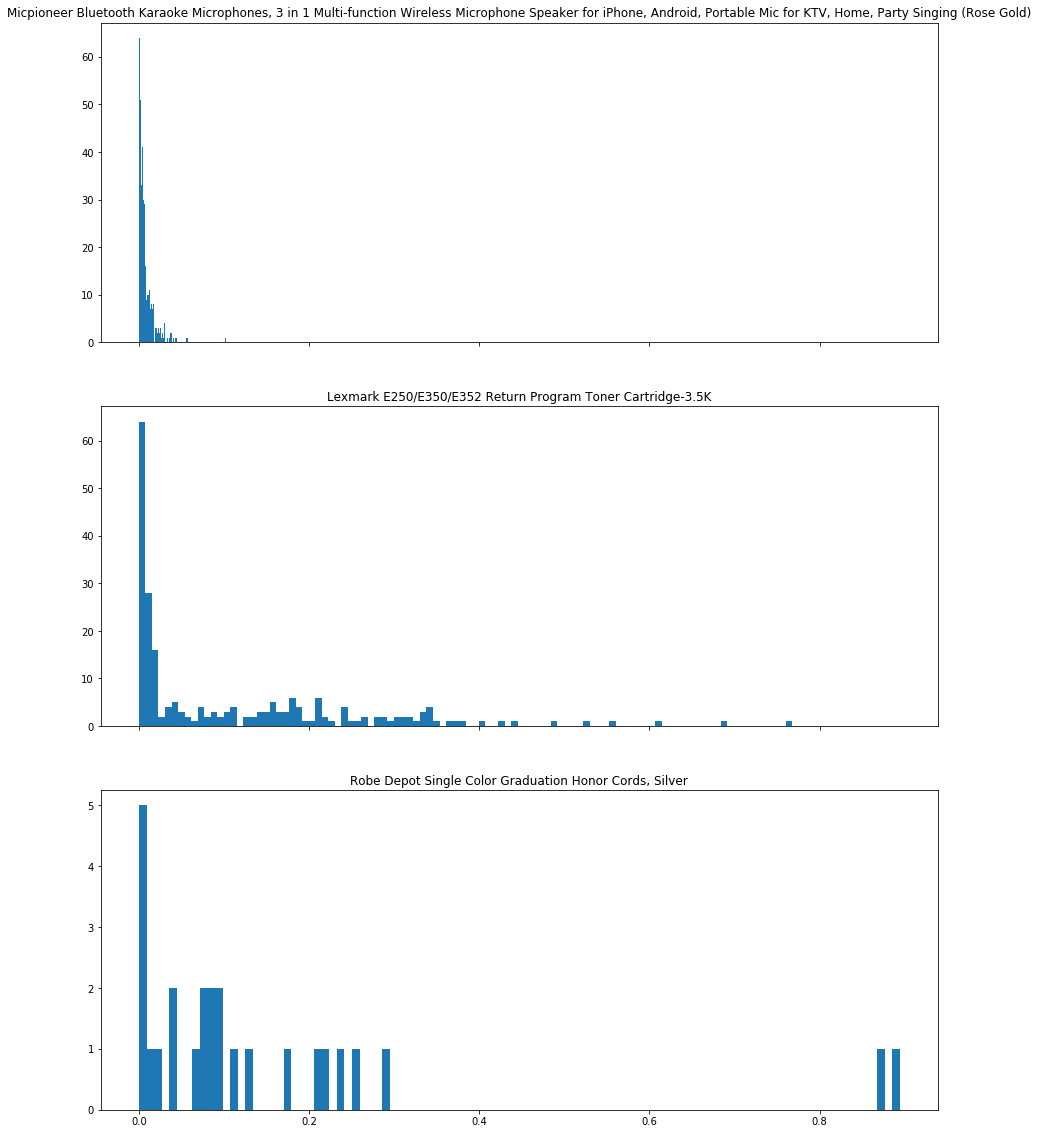

In [5]:
def drop_extractor(rankts,norm):
    """Calculates the magnitude of every sales rank drop in the time series data.
    
    Each of the drops mentioned above are represented as differences between the sales rank divided by a normalizing factor.
    If norm is set as None, then each decrease in rank is instead divided by the rank value right before the decrease.
    
    So far, I find that setting norm as None gets us the best results.
    
    Arguments:
       rankts (list of tuples): The sales rank history data for a product.
       norm (int): The normalization factor (currently set as the maximum sales rank in the product's history)
       
    Returns:
       A list of all of the calculated drops.
    """
    drops = []
    if norm == None:
        for i in range(1,len(rankts)):
            if rankts[i][1]-rankts[i-1][1] < 0:
                drops.append((rankts[i-1][1]-rankts[i][1])/rankts[i-1][1])
    else:
        for i in range(1,len(rankts)):
            if rankts[i][1]-rankts[i-1][1] < 0:
                drops.append((rankts[i-1][1]-rankts[i][1])/norm)
    return drops
fig,ax = plt.subplots(3,1,figsize=(15,20),sharex = True)
for i in range(3):
    y = hist_list[i]['SALES']
    maxrank = max([x[1] for x in y])
    recentdate = max([x[0] for x in y])
    y = [x for x in y if x[0] > recentdate - datetime.timedelta(180)]
    drop = drop_extractor(y,maxrank)
    ax[i].hist(drop,bins = 100)
    ax[i].title.set_text(hist_list[i]['title'])

I noticed that most products consistently has its highest bar set in the leftmost bin. This is expected since that bin represents a very small drop, which likely signifies the data's noise. The other bins, representing greater proportional change, likely signifies actual orders.

The goal now is to find a heuristic to seperate the drops due to orders from the drops due to noise. An idea I had was to take the cdf of the product's drop proportion list, and pinpointing when the tangent line became less than 1 as the divider between the orders and the noise. In other words, I would sort that drop list, and determine the first point in which the difference between that point and the next is greater than 1/(n-1). My reasoning for this is since there are generally a lot of drops due to noise, which are generally tightly packed, there may be a distance that seperates the noise and orders.

I also want to experiment with different values of slopes, to see if changing the slope heuristic would significantly change the order drop estimate.

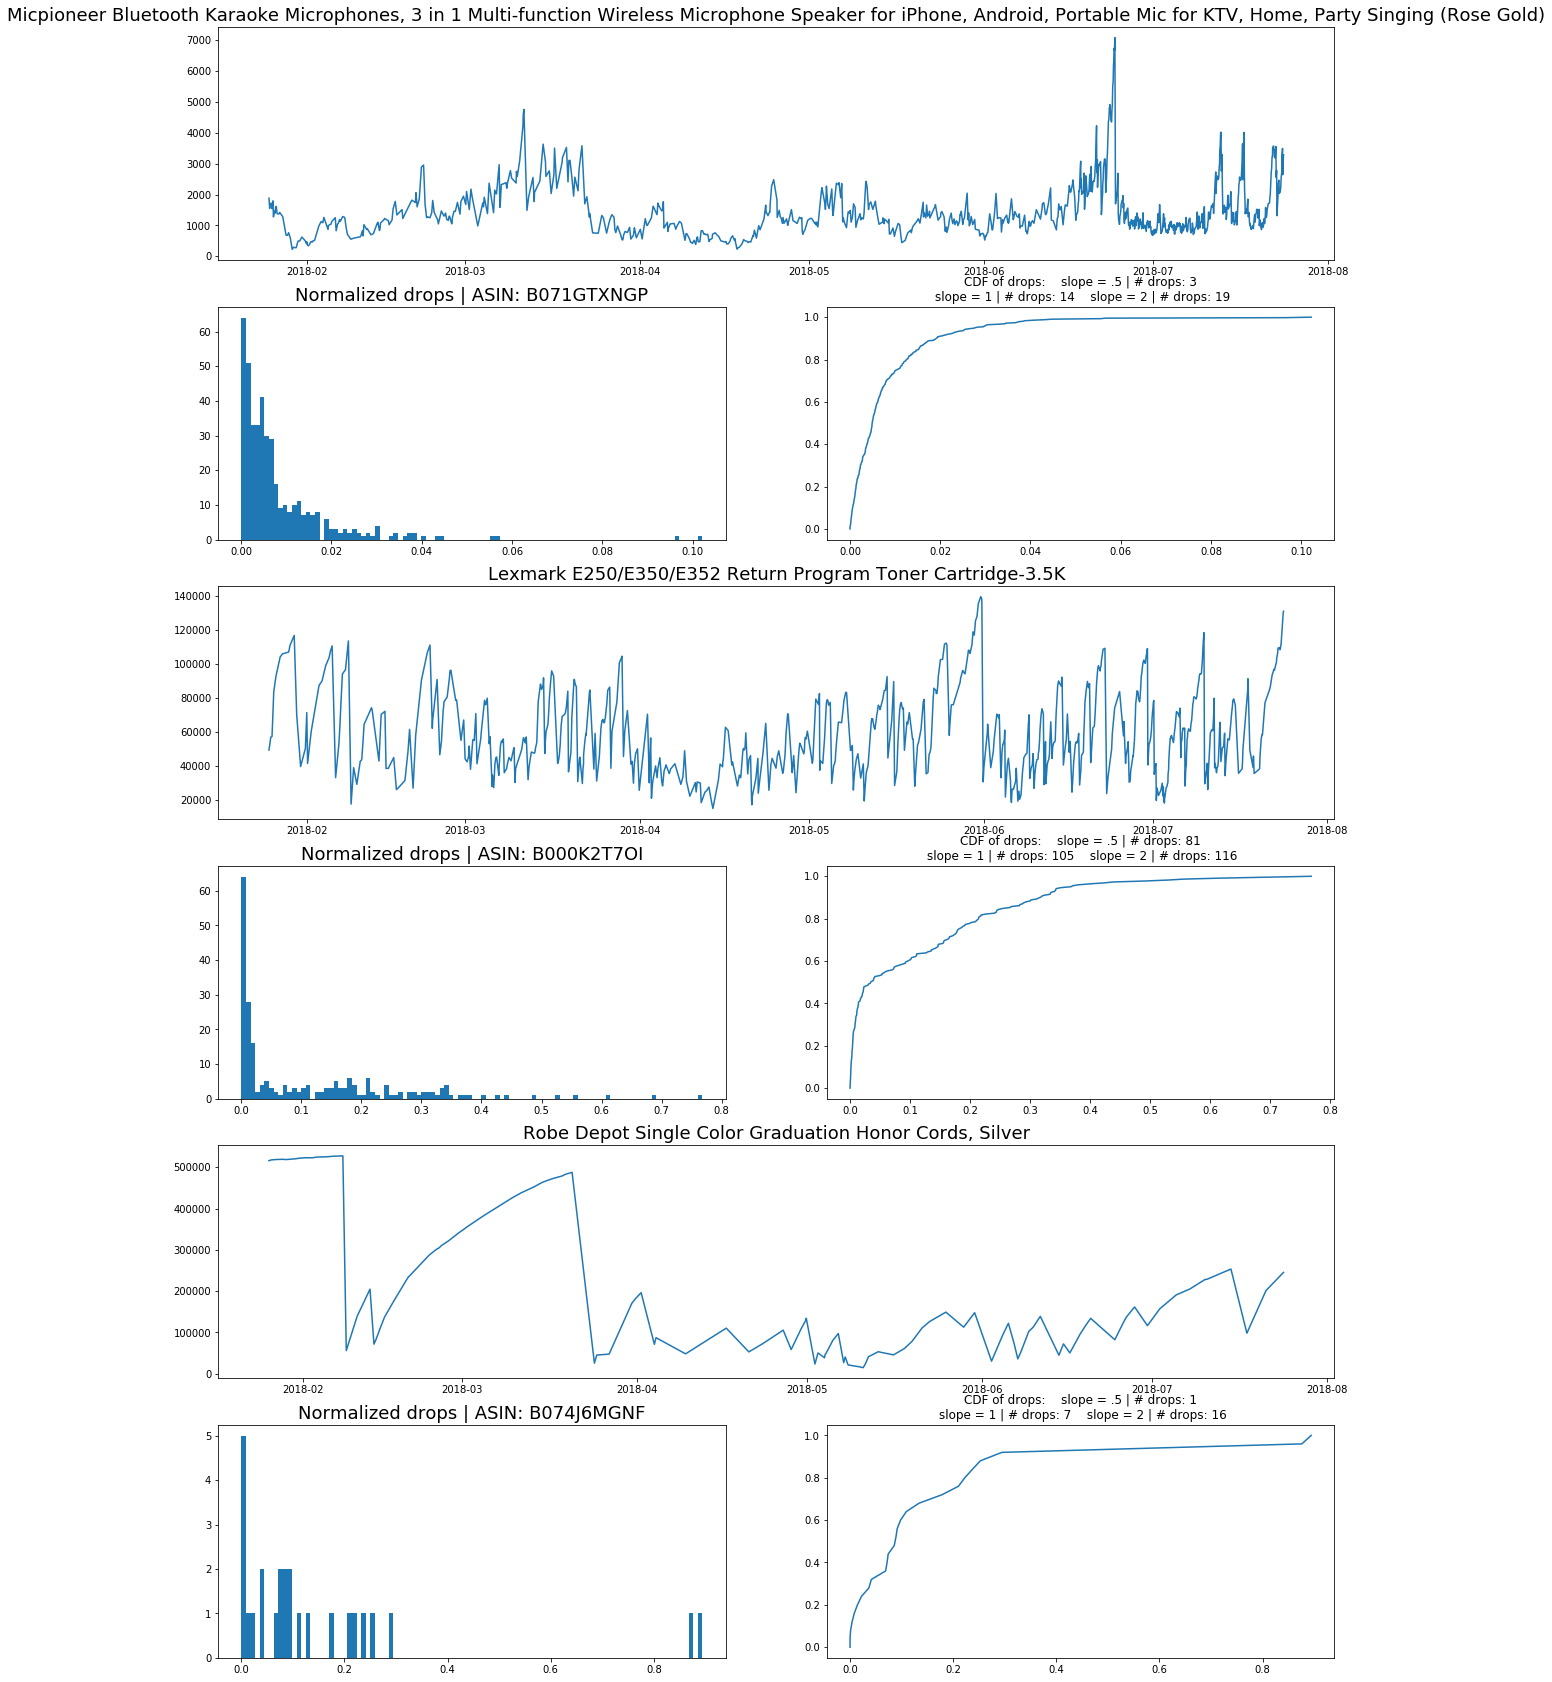

In [6]:
def cdf_creator(drop):
    """Generates the CDF from the inputted list and calculates the location of several slope values within that list.
    
    This function generates values for a cdf so that if we called plot(drop,cdfy) after calling this function,
    we would create a cdf of the inputted list. This function also finds the positions in the inputted list in which
    the slope of the cdf at that point is less than .5, 1, and 2. In the code, I display these values in the title of my generated plots.
    
    Arguments:
       drop (list): The list of proportional drops from the time-series data.
       
    Returns:
       n (int): The length of the inputted list.
       cdfy (list): The y-component of the cdf.
       halfslope (int): The position of the list in which the slope of the tangent line of the generated cdf is less than .5
       oneslope (int): The position of the list in which the slope of the tangent line of the generated cdf is less than 1
       twoslope (int): The position of the list in which the slope of the tangent line of the generated cdf is less than 2
    """
    n = len(drop)
    cdfy = np.linspace(0,1,n)
    halfslope = oneslope = twoslope = n-1
    for j in range(1,n):
        if drop[j]-drop[j-1] == 0:
            slope = np.inf
        else:
            slope = (cdfy[j]-cdfy[j-1])/(drop[j]-drop[j-1])
        if slope < .5 and halfslope == n-1:
            halfslope = j
        if slope < 1 and oneslope == n-1:
            oneslope = j
        if slope < 2 and twoslope == n-1:
            twoslope = j
    return n,cdfy,halfslope,oneslope,twoslope

fig = plt.figure(figsize=(20,30))
for i in range(3):
    y = hist_list[i]['SALES']
    ax = plt.subplot(6,1,1 + i*2)
    maxrank = max([x[1] for x in y])
    recentdate = max([x[0] for x in y])
    y = [x for x in y if x[0] > recentdate - datetime.timedelta(180)]
    drop = drop_extractor(y,maxrank)
    drop.sort()
    ax.plot([x[0] for x in y],[x[1] for x in y])
    plt.title(hist_list[i]['title'],fontsize = 18)

    ax = plt.subplot(6,2,3 + i*4)
    ax.hist(drop,bins = 100)
    plt.title('Normalized drops | ASIN: ' + hist_list[i]['asin'],fontsize = 18)

    ax = plt.subplot(6,2,4 + i*4)
    n,cdfy,halfslope,oneslope,twoslope = cdf_creator(drop)
    ax.plot(drop,cdfy)
    plt.title('CDF of drops:    slope = .5 | # drops: ' + str(n-1-halfslope)+ '\n slope = 1 | # drops: ' + str(n-1-oneslope) +'    slope = 2 | # drops: ' + str(n-1-twoslope))

After looking at these plots for many products, I realized that my drop function assigns the same value to every change in sales rank within the same product, regardless of where the drop started. An example of this is where a popular item suddenly stops getting sales for a short period, which increases its sales rank by a lot. For those products, even if they sell a lot, my drop heuristic would incorrectly categorize all their drops in the lower ranks as noise.

To fix this, I changed my drop function so that it divides each decrease in rank by the rank before the decrease. Now, each drop would represent a true proportional decrease of sales rank from one point to the next. This way, each drop proportion is independent of the other drops. I also included the cdf of this function.

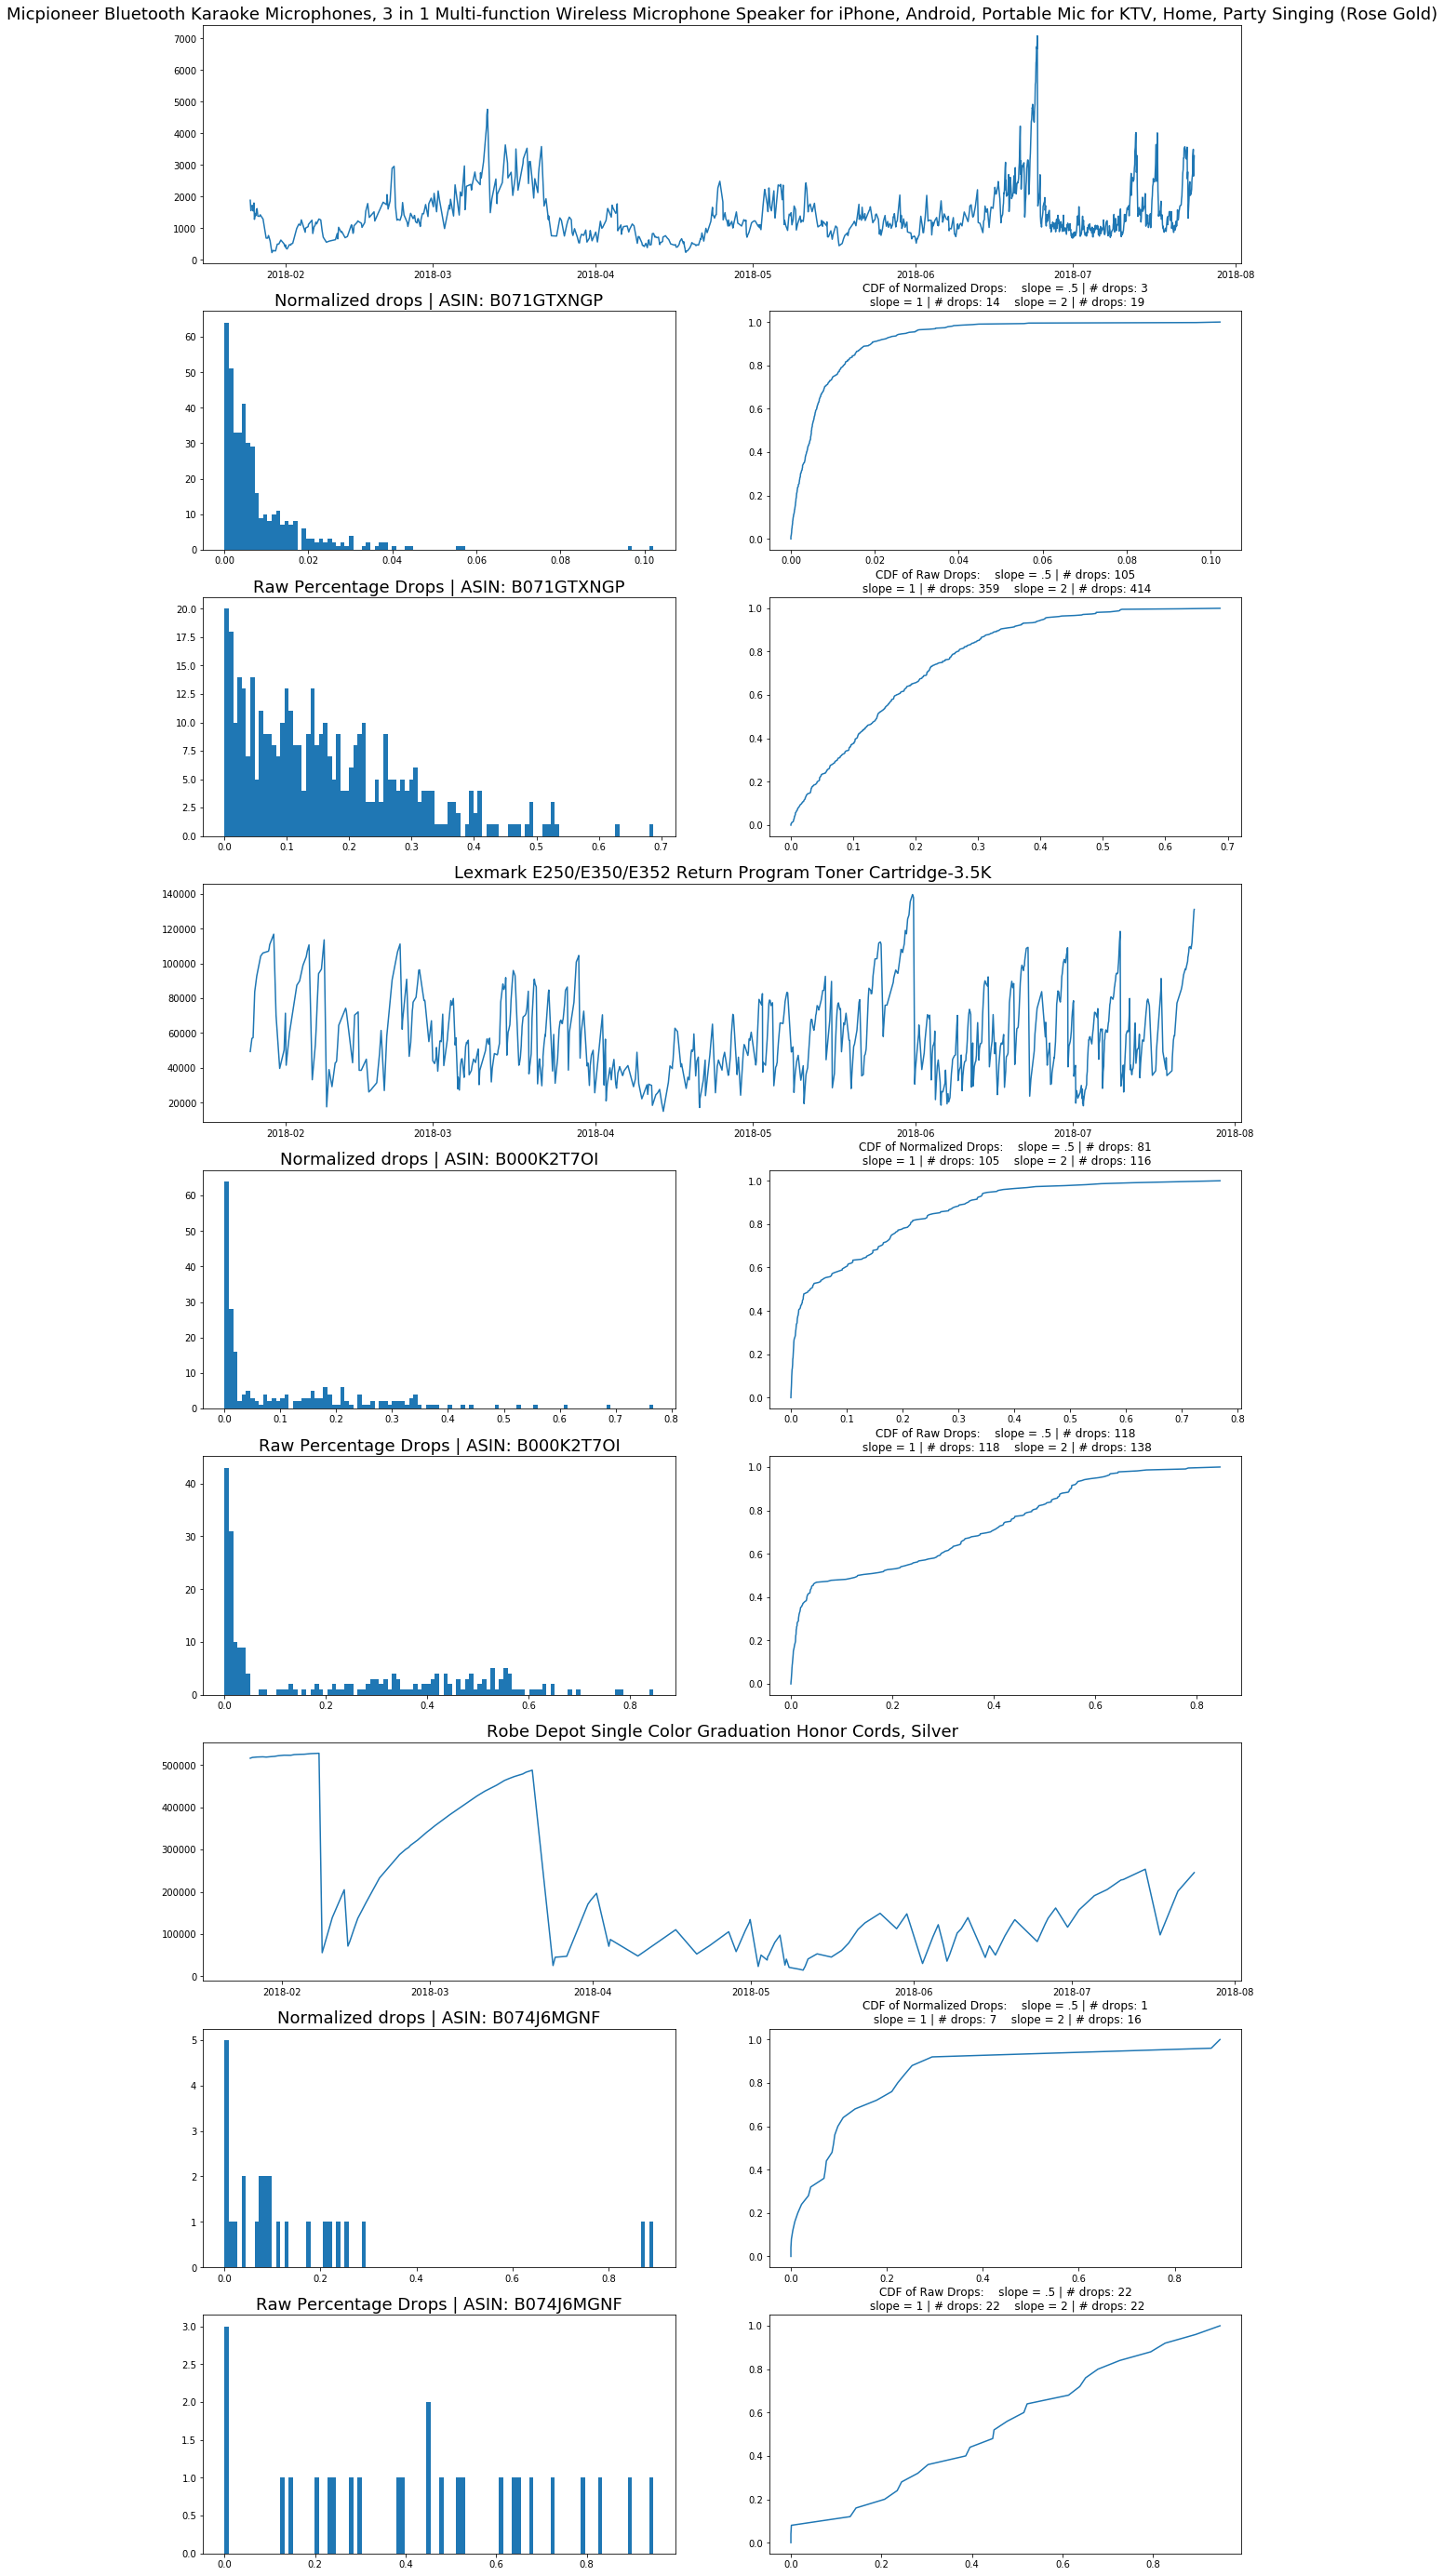

In [7]:
fig = plt.figure(figsize=(20,50))
for i in range(3):
    y = hist_list[i]['SALES']
    ax = plt.subplot(9,1,1 + i*3)
    maxrank = max([x[1] for x in y])
    recentdate = max([x[0] for x in y])
    y = [x for x in y if x[0] > recentdate - datetime.timedelta(180)]
    
    drop = drop_extractor(y,maxrank)
    drop.sort()
    ax.plot([x[0] for x in y],[x[1] for x in y])
    plt.title(hist_list[i]['title'],fontsize = 18)

    ax = plt.subplot(9,2,3 + i*6)
    ax.hist(drop,bins = 100)
    plt.title('Normalized drops | ASIN: ' + hist_list[i]['asin'],fontsize = 18)

    ax = plt.subplot(9,2,4 + i*6)
    n,cdfy,halfslope,oneslope,twoslope = cdf_creator(drop)
    ax.plot(drop,cdfy)
    plt.title('CDF of Normalized Drops:    slope = .5 | # drops: ' + str(n-1-halfslope)+ '\n slope = 1 | # drops: ' + str(n-1-oneslope) +'    slope = 2 | # drops: ' + str(n-1-twoslope))
    
    drop = drop_extractor(y,None)
    drop.sort()

    ax = plt.subplot(9,2,5 + i*6)
    ax.hist(drop,bins = 100)
    plt.title('Raw Percentage Drops | ASIN: ' + hist_list[i]['asin'],fontsize = 18)

    ax = plt.subplot(9,2,6 + i*6)
    n,cdfy,halfslope,oneslope,twoslope = cdf_creator(drop)
    ax.plot(drop,cdfy)
    plt.title('CDF of Raw Drops:    slope = .5 | # drops: ' + str(n-1-halfslope)+ '\n slope = 1 | # drops: ' + str(n-1-oneslope) +'    slope = 2 | # drops: ' + str(n-1-twoslope))

After looking at more plots, I noticed that the drop plots for the non-normalized drop function has a more pronounced split between the leftmost bin and the rest of the data. The number of significant drops from the differing slopes also agreed more than that of the normalized drop function.

## Conclusion
As it is now, there are still a lot of problems with the drop heuristic. It is inherently limiting since looking at the drops in the sales rank data gives you only a rough lower bound on the SPM, since even if you can identify a significant drop, you can only say that there has probably been at least one sale during that drop. 

However, given the lack of objective sales data and with the analysis I have so far, it is safe to say that this drop heuristic is an acceptable lower bound for the number of sales a product has.

If more time is put into this though, it may provide with a usable lower bound estimate for a product's SPM, which is meaningful.